In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import math
import copy
import joblib
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import check_random_state
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, classification_report, ConfusionMatrixDisplay
  


Загрузим дату титаника и удалим все лишнее

In [2]:
d1 = pd.read_csv('titanic_data.csv')
d2 = pd.read_csv('titanic_surv.csv')
data = pd.concat([d1, d2], axis=1)

In [3]:
data = data.drop(columns=['Cabin'])

In [4]:
mean = data['Age'].mean()
std = data['Age'].std()
number_of_nulls = data['Age'].isnull().sum()
random_ages = np.random.randint(mean - std, mean + std, size=number_of_nulls)

In [5]:
new_ages = data['Age'].copy()
new_ages[np.isnan(new_ages)] = random_ages
data['Age'] = new_ages

In [6]:
data = data[data['Embarked'].notnull()]

In [7]:
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data['Embarked'] = data['Embarked'].map({"S": 0, "C": 1, "Q": 2})

In [8]:
data = data.drop(columns=['Name', 'PassengerId', 'Ticket'])

In [9]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,0,22.0,1,0,7.2500,0,0
1,1,1,38.0,1,0,71.2833,1,1
2,3,1,26.0,0,0,7.9250,0,1
3,1,1,35.0,1,0,53.1000,0,1
4,3,0,35.0,0,0,8.0500,0,0


#Разделим на тестовую и обучающую выборки

In [10]:
train, test = train_test_split(data, test_size=0.2)

In [11]:
train.shape, test.shape

((711, 8), (178, 8))

In [12]:
x_train = train.drop(columns=['Survived'])
y_train = train['Survived']

In [13]:
x_test = test.drop(columns=['Survived'])
y_test = test['Survived']

#Логистическая регрессия

In [14]:
class LR(BaseEstimator, ClassifierMixin):
    def __init__(self, step=10**-2, it_c=1):
        self.step = step
        self.it_c = it_c

    def get_coeff(self, x, y):
        err = 0
        x = x.to_numpy()
        y = y.to_numpy()
        
        for i in range(len(y)): 
            if self.predict(x[i]) == y[i]:
                err += 1
        return err / len(y)
    
    def fit(self, x, y):
        x = x.to_numpy()
        y = y.to_numpy()
        np.c_[x, np.ones(len(x))] 
        self.w = np.zeros(x.shape[1])
        for i in range(self.it_c):
            z = [sum([x[i][j]*self.w[j] for j in range(len(x[i]))]) for i in range(len(x))]
            res = np.array([1 / (1 + np.exp(-a)) for a in z])
            grad = np.dot(x.T, res - y) / y.size
            self.w -= self.step * grad
    def predict(self, x):
        np.append(x,1)
        return (1 / (1 + np.exp(-np.dot(x, self.w)))).round()

Настройка гиперпараметров:

In [15]:
param_grid = {'max_iter': [500,1000,2000,3000]}
base_estimator = LogisticRegression()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(x_test, y_test)
sh.best_estimator_

LogisticRegression(max_iter=500)

In [16]:
# Моя реализация

param_grid = {'step': [1, 2, 3, 5, 10]}
base_estimator = LR()
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=2).fit(x_test, y_test)
sh.best_estimator_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/pyth

LR(step=5)

In [17]:
mlg = LR(step=5)
hist = mlg.fit(x_train, y_train)
print(f"моя LR: {mlg.get_coeff(x_test, y_test)}")

моя LR: 0.7191011235955056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp


In [18]:
sklg = LogisticRegression(max_iter=500)
sklg.fit(x_train, y_train)
print(f"sklearn: {sklg.score(x_test, y_test)}")

sklearn: 0.8033707865168539


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp


threshold: [2. 1. 0.]
false_positive: [0.         0.16260163 1.        ]
true_positive: [0.         0.45454545 1.        ]
AUC: 0.6459719142645972





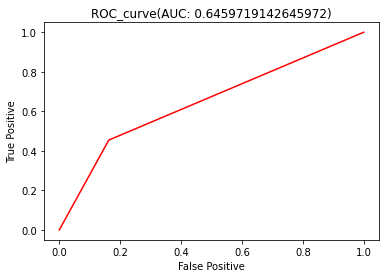

In [19]:
y_pred_test = mlg.predict(x_test)
false_positive, true_positive, threshold = roc_curve(y_test, y_pred_test, pos_label=1) 
print('threshold: ' + str(threshold))
print('false_positive: ' + str(false_positive))
print('true_positive: ' + str(true_positive))
AUC = auc(false_positive, true_positive) 
print('AUC: ' + str(AUC))
print('\n\n')
plt.plot(false_positive, true_positive, 'r')  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive')  
plt.xlabel('False Positive')  
plt.show()

In [20]:
y_pred_train = mlg.predict(x_train)
y_pred_test = mlg.predict(x_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp


In [21]:
recall_score(y_train, y_pred_train)

0.4842105263157895

In [22]:
recall_score(y_test, y_pred_test)

0.45454545454545453

In [23]:
precision_score(y_train, y_pred_train)


0.6359447004608295

In [24]:
precision_score(y_test, y_pred_test)


0.5555555555555556

In [25]:
confusion_matrix(y_train, y_pred_train)

array([[347,  79],
       [147, 138]])

In [26]:
confusion_matrix(y_test, y_pred_test)

array([[103,  20],
       [ 30,  25]])

In [27]:
accuracy_score(y_train, y_pred_train)

0.6821378340365682

In [28]:
accuracy_score(y_test, y_pred_test)

0.7191011235955056

In [29]:
joblib.dump(param_grid, "linear_regression.pkl")

['linear_regression.pkl']

#KNN

In [30]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self,K,x,y):
        self.K = K
        self.x = x.to_numpy()
        self.y = y.to_numpy()
    
    def fit(self,x,y):
        x = x.to_numpy()
        res = []
        err = 0
        for d in range(len(x)):
            dist = []
            for i in range(len(self.x)):
                dd = [(x[d][idx] - self.x[i][idx])**2 for idx in range(len(self.x[i]))]
                dist.append([sum(dd)**0.5, self.y[i]])   
            dist = sorted(dist)[:self.K]
            inverse_distances = [1/c[0] for c in dist]   
            sum_of_inverses = sum(inverse_distances)
            weights = [[inverse / sum_of_inverses, dist[idx][1]] for idx, inverse in enumerate(inverse_distances)]
            prob = {c : 0 for c in y.unique()}
            for el in weights:
                prob[el[1]] += el[0]
            res.append(max(prob, key=prob.get))
            if res[-1] == y.to_numpy()[d]:
                err += 1
        return err / len(y.to_numpy())

    def predict(self,f):
        decision = np.dot(f, self.coef.T)
        pred = decision.argmax(axis=0)
        return pred

Настройка гиперпараметров:

In [31]:
param_grid = {'leaf_size': [ 1, 2, 3, 5, 10],
              'n_neighbors': [ 1, 2, 3, 5, 10, 20, 30],
              'n_jobs': [ 1, 2, 3]}
base_estimator = KNeighborsClassifier(5)

sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(x_test, y_test)
sh.best_estimator_

KNeighborsClassifier(leaf_size=1, n_jobs=1, n_neighbors=10)

In [32]:
model = KNN(7,x_train,y_train)
model.fit(x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0.5898876404494382

In [33]:
scores = []
for i in range(2, 50):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append((y_test == y_pred).sum() / len(y_test))
max(scores)

0.7584269662921348

Нормированная дата

In [34]:
X_train_normalized = x_train.apply(lambda x: (x-x.mean()) / x.std(), axis=0)
X_test_normalized = x_test.apply(lambda x: (x-x.mean()) / x.std(), axis=0)
scores = []
for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_normalized, y_train)
    Y_pred = knn.predict(X_test_normalized)
    scores.append((y_test == Y_pred).sum() / len(y_test))
max(scores)

0.8146067415730337

threshold: [2 1 0]
false_positive: [0.         0.08130081 1.        ]
true_positive: [0.         0.25454545 1.        ]
AUC: 0.5866223207686622





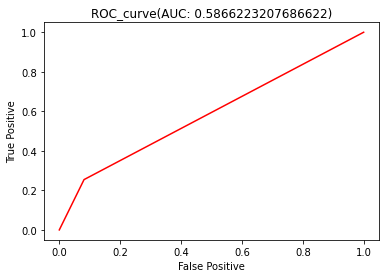

In [35]:
y_pred_test = sh.predict(x_test)
false_positive, true_positive, threshold = roc_curve(y_test, y_pred_test, pos_label=1) 
print('threshold: ' + str(threshold))
print('false_positive: ' + str(false_positive))
print('true_positive: ' + str(true_positive))
AUC = auc(false_positive, true_positive) 
print('AUC: ' + str(AUC))
print('\n\n')
plt.plot(false_positive, true_positive, 'r')  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive')  
plt.xlabel('False Positive')  
plt.show()


In [36]:
y_pred_train = sh.predict(x_train)
y_pred_test = sh.predict(x_test)


In [37]:
recall_score(y_train, y_pred_train)

0.2736842105263158

In [38]:
recall_score(y_test, y_pred_test)

0.2545454545454545

In [39]:
precision_score(y_train, y_pred_train)


0.65

In [40]:
precision_score(y_test, y_pred_test)


0.5833333333333334

In [41]:
confusion_matrix(y_train, y_pred_train)

array([[384,  42],
       [207,  78]])

In [42]:
confusion_matrix(y_test, y_pred_test)

array([[113,  10],
       [ 41,  14]])

In [43]:
accuracy_score(y_train, y_pred_train)

0.6497890295358649

In [44]:
accuracy_score(y_test, y_pred_test)

0.7134831460674157

In [45]:
joblib.dump(param_grid, "knn.pkl")

['knn.pkl']

#NaiveBayesClassifier

In [46]:
class NBC(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self,x,y):
        self.classes = np.unique(y)
        x = x.to_numpy()
        y = y.to_numpy()
        
        mean = []
        for j in range(len(x[0])):
            r = []
            for clas in self.classes:
                s = []
                num = 0
                for i in range(len(x)):
                    if y[i] == clas:
                        s.append(x[i][j])
                        num += 1
                r.append(sum(s) / num)
            mean.append(r)
        self.mean = mean
        
        stdev = []
        for j in range(len(x[0])):
            r = []
            for clas in range(len(self.classes)):
                s = []
                num = 0
                for i in range(len(x)):
                    if y[i] == self.classes[clas]:
                        s.append(pow(x[i][j] - mean[j][clas],2))
                        num += 1
                r.append(sum(s) / (num-1))
            stdev.append(r)
        self.stdev = stdev
        
    def predict(self,x):
        res = []
        for clas in range(len(self.classes)):
            r = 1
            for j in range(len(x)):
                r *= (np.exp((-1/2) * ((x[j]-self.mean[j][clas])**2) / (2 * self.stdev[j][clas])) / np.sqrt(2 * np.pi * self.stdev[j][clas]))
            res.append(r)
        m = 0
        answ = -1
        for clas in range(len(self.classes)):
            if res[clas] > m:
                m = res[clas]
                answ = self.classes[clas]
        return answ
    
    def predictAll(self,x,y):
        x = x.to_numpy()
        y = y.to_numpy()
        
        err = 0
        res = []
        for i in range(len(x)):
            answ = self.predict(x[i])
            res.append(answ)
            if answ == y[i]:
                err += 1
            
        return res, err / len(x)

Настройка гиперпараметров:

In [47]:
param_grid = {'var_smoothing': [1, 2, 3, 5, 10]}
base_estimator = GaussianNB()
for parametr in base_estimator.get_params().keys():
  print(parametr)
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(x_test, y_test)
sh.best_estimator_

priors
var_smoothing


GaussianNB(var_smoothing=1)

In [48]:
nbc = NBC()
nbc.fit(x_train, y_train)
res,err = nbc.predictAll(x_test,y_test)
err

0.7921348314606742

In [49]:
gaussian = GaussianNB(var_smoothing=3) 
gaussian.fit(x_train, y_train) 
y_pred = gaussian.predict(x_test)  
gaussian.score(x_train, y_train)

0.6104078762306611

threshold: [2 1 0]
false_positive: [0.         0.16431925 1.        ]
true_positive: [0.         0.70175439 1.        ]
AUC: 0.7687175685693106





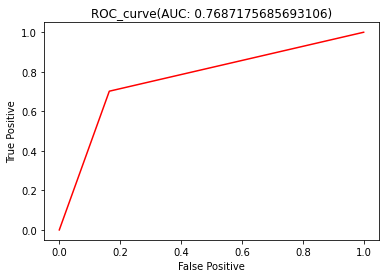

In [50]:
y_pred_test = nbc.predictAll(x_train, y_train)
false_positive, true_positive, threshold = roc_curve(y_train, y_pred_test[0], pos_label=1) 
print('threshold: ' + str(threshold))
print('false_positive: ' + str(false_positive))
print('true_positive: ' + str(true_positive))
AUC = auc(false_positive, true_positive) 
print('AUC: ' + str(AUC))
print('\n\n')
plt.plot(false_positive, true_positive, 'r')  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive')  
plt.xlabel('False Positive')  
plt.show()

In [51]:
y_pred_train = nbc.predictAll(x_train, y_train)
y_pred_test = nbc.predictAll(x_test, y_test)


In [52]:
recall_score(y_train, y_pred_train[0])

0.7017543859649122

In [53]:
recall_score(y_test, y_pred_test[0])

0.6545454545454545

In [54]:
precision_score(y_train, y_pred_train[0])

0.7407407407407407

In [55]:
precision_score(y_test, y_pred_test[0])


0.6666666666666666

In [56]:
confusion_matrix(y_train, y_pred_train[0])

array([[356,  70],
       [ 85, 200]])

In [57]:
confusion_matrix(y_test, y_pred_test[0])

array([[105,  18],
       [ 19,  36]])

In [58]:
accuracy_score(y_train, y_pred_train[0])

0.7819971870604782

In [59]:
accuracy_score(y_test, y_pred_test[0])

0.7921348314606742

In [60]:
joblib.dump(param_grid, "naive_bause.pkl")

['naive_bause.pkl']

#SVM - Support Vector Machine


In [61]:
def projection_simplex(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [62]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1, max_iter=100, eps=0.01, random_state=None, verbose=0):
        self.C = C
        self.max_iter = max_iter
        self.eps = eps
        self.random_state = random_state
        self.verbose = verbose

    def partial_gradient(self,f, t, i):
        print(f[0],self.coef.T)
        f = f.to_numpy()
        g = np.dot(f[i], self.coef.T) + 1
        g[int(t[i])] -= 1
        return g

    def violation(self, g, t, i):
        smallest = np.inf
        for k in range(g.shape[0]):
            if k == t[i] and self.dual_coef[k, i] >= self.C:
                continue
            elif k != t[i] and self.dual_coef[k, i] >= 0:
                continue

            smallest = min(smallest, g[k])
        return g.max() - smallest

    def solver(self, g, t, norms, i):
        Ci = np.zeros(g.shape[0])
        Ci[int(t[i])] = self.C
        beta_hat = norms[i] * (Ci - self.dual_coef[:, i]) + g / norms[i]
        z = self.C * norms[i]
        beta = projection_simplex(beta_hat, z)
        return Ci - self.dual_coef[:, i] - beta / norms[i]

    def fit(self,f, t):
        n_samples, n_features =f.shape
        n_classes = 4
        self.dual_coef = np.zeros((n_classes, n_samples), dtype=np.float64)
        self.coef = np.zeros((n_classes, n_features))
        norms = np.sqrt(np.sum(f ** 2, axis=1))
        rs = check_random_state(self.random_state)
        ind = np.arange(n_samples)
        rs.shuffle(ind)
        violation_init = None
        for it in range(self.max_iter):
            violation_sum = 0
            for idx in range(n_samples):
                i = ind[idx]

                if norms[i] == 0:
                    continue
                g = self.partial_gradient(f, t, i)
                v = self.violation(g, t, i)
                violation_sum += v
                if v < 1e-12:
                    continue
                delta = self.solver(g, t, norms, i)
                self.coef += (delta *f[i][:, np.newaxis]).T
                self.dual_coef[:, i] += delta
            if it == 0:
                violation_init = violation_sum
            vratio = violation_sum / violation_init
            if self.verbose >= 1:
                print("iter", it + 1, "violation", vratio)
            if vratio < self.eps:
                if self.verbose >= 1:
                    print("Converged")
                break
        return self

    def predict(self,f):
        decision = np.dot(f, self.coef.T)
        pred = decision.argmax(axis=0)
        return pred

    def get_coeff(self, features, target):
        cnt = 0
        for i in range(target.shape[0]):
            if self.predict(features[i]) == target[i]:
                cnt += 1
        return cnt / target.shape[0]

Настройка гиперпараметров:

In [63]:

param_grid = {'break_ties': [2, 3, 5, 10],
              'cache_size': [1, 2, 3, 5, 10],
              'gamma': [0.001, 0.0001]}
base_estimator = SVC(decision_function_shape='ovr')

sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(x_test, y_test)
sh.best_estimator_

SVC(break_ties=2, cache_size=1, gamma=0.001)

In [64]:
svc = SVC(break_ties=2, cache_size=1, gamma=0.0001)
svc.fit(x_train, y_train)
print('Результат реализации sklearn: {}'
.format(svc.score(x_train, y_train)))

Результат реализации sklearn: 0.6694796061884669


threshold: [2 1 0]
false_positive: [0.         0.09624413 1.        ]
true_positive: [0.         0.31929825 1.        ]
AUC: 0.6115270570793181





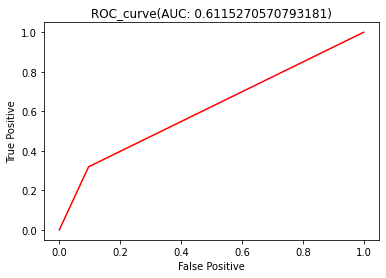

In [65]:
y_pred_test = svc.predict(x_train)
false_positive, true_positive, threshold = roc_curve(y_train, y_pred_test, pos_label=1) 
print('threshold: ' + str(threshold))
print('false_positive: ' + str(false_positive))
print('true_positive: ' + str(true_positive))
AUC = auc(false_positive, true_positive) 
print('AUC: ' + str(AUC))
print('\n\n')
plt.plot(false_positive, true_positive, 'r')  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive')  
plt.xlabel('False Positive')  
plt.show()

In [66]:
y_pred_train = svc.predict(x_train)
y_pred_test = svc.predict(x_test)


In [67]:
recall_score(y_train, y_pred_train)

0.3192982456140351

In [68]:
recall_score(y_test, y_pred_test)

0.2909090909090909

In [69]:
precision_score(y_train, y_pred_train)


0.6893939393939394

In [70]:
precision_score(y_test, y_pred_test)


0.6666666666666666

In [71]:
confusion_matrix(y_train, y_pred_train)

array([[385,  41],
       [194,  91]])

In [72]:
confusion_matrix(y_test, y_pred_test)

array([[115,   8],
       [ 39,  16]])

In [73]:
accuracy_score(y_train, y_pred_train)

0.6694796061884669

In [74]:
accuracy_score(y_test, y_pred_test)

0.7359550561797753

In [75]:
joblib.dump(param_grid, "svm.pkl")

['svm.pkl']